In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

price_per_kg = 5000 #$/kg to orbit
cruise_ops_cost = 1e6/30 #$/day of cruise phase Mission Operations

#--#--#--#--#-- ENTER MISSION PROFILE PARAMETERS --#--#--#--#--#

##ELECTRIC PROPULSION
dT_trans = 93 #days
dV = 8000 #m/s for LEO to LLO with low-thrust

##CHEMICAL PROPULSION
dT_trans_cp = 4 #days
dV_cp = 4040 #m/s

#--#--#--#--#-- ENTER PROPULSION SUBSYSTEM PARAMETERS --#--#--#--#--#

##ELECTRIC PROPULSION
n_F = 0.72 #total thrust efficiency
F = 6 #N
Isp = 5000*9.81 #m/s
thruster_lifetime = 50000 #hours
alfa_p = 0.10 #kg/kg, percentage of propellant management unit mass per kg of propellant
#Note: specific mass of thruster is defined below

##CHEMICAL PROPULSION
Isp_cp = 450*9.81 #m/s

#--#--#--#--#-- ENTER POWER SUBSYSTEM PARAMETERS --#--#--#--#--#

n_e = 0.45 #electrical conversion efficiency
beta_sp = 3.3 #kg/kW, power density of solar-power based power subsystem
areal_power_sp = 2.5 #m2/kW

#--#--#--#--#-- Mission with Electric Propulsion --#--#--#--#--#

m_prop = F*(dT_trans*24*3600)/(Isp) #kg
P_e = F*Isp/(2*n_F*1000) #kW
P = P_e/n_e #kW
beta_thruster = 1.2 + 444/P_e #kg/kW, power density of hight power helicon thruster, including power processing unit

m_dry = beta_thruster*P_e + beta_sp*P + alfa_p*m_prop + 250 #kg
m_pay = m_prop/(np.exp(dV/Isp)-1) - m_dry #kg
m_0 = m_dry + m_prop + m_pay #kg
n_trips = thruster_lifetime/(dT_trans*24) #number of one-way missions doable by the space-tug

print("Propellant mass of %.0f kg for a dry mass of %.0f kg, total mass at BOL of %.0f kg"%(m_prop, m_dry, m_0))
print("Solar panel area of %.0f m2 with mass of %.2f kg for a total power of %.2f kW, electrical power of %.2f kW. \n"%(areal_power_sp*P ,beta_sp*P, P, P_e))
print("Allowed payload mass per trip of %.0f kg"%(m_pay))
print("Allowed number of trips until thruster failure: %.0f"%(n_trips))
print("Total cargo between the Earth to the Moon: %.0f tons\n\n"%(n_trips*m_pay/1000))

#--#--#--#--#-- Mission with Chemical Propulsion --#--#--#--#--#

m_prop_cp = m_pay*(1-np.exp(-dV_cp/Isp_cp))/((1+alfa_p)*np.exp(-dV_cp/Isp_cp)-alfa_p) #
m_dry_cp = alfa_p*m_prop_cp #




delta_m_prop = m_prop_cp - m_prop
delta_m_dry = m_dry_cp - m_dry
delta_mission_duration = dT_trans - dT_trans_cp
CP_mission_cost = ((m_prop_cp + m_pay + m_dry_cp)*price_per_kg + dT_trans_cp*cruise_ops_cost)/1e6
EP_mission_cost = ((m_prop + m_pay + m_dry/n_trips)*price_per_kg + dT_trans*cruise_ops_cost)/1e6
total_savings = ((n_trips*(delta_m_prop + m_dry_cp) - m_dry)*price_per_kg - n_trips*cruise_ops_cost*delta_mission_duration)/1e6

print("Propellant cost with chemical propulsion of %.0f kg, for a delta of %.0f kg"%(m_prop_cp, delta_m_prop))
print("For a payload of %.0f kg, each mission using the space tug would be %.1f M$ cheaper, saving the taxpayer a total of %.1f M$"%(m_pay,CP_mission_cost-EP_mission_cost,total_savings))

Propellant mass of 983 kg for a dry mass of 2536 kg, total mass at BOL of 6531 kg
Solar panel area of 1135 m2 with mass of 1498.75 kg for a total power of 454.17 kW, electrical power of 204.38 kW. 

Allowed payload mass per trip of 3012 kg
Allowed number of trips until thruster failure: 22
Total cargo between the Earth to the Moon: 67 tons


Propellant cost with chemical propulsion of 5304 kg, for a delta of 4321 kg
For a payload of 3012 kg, each mission using the space tug would be 20.7 M$ cheaper, saving the taxpayer a total of 464.2 M$


In [59]:
def mission_analysis(dT_trans, F=6, Isp=5000*9.81, thruster_lifetime=50000, dV=8000,
                       dT_trans_cp =4, Isp_cp=4500, dV_cp = 4040, price_per_kg = 5000, cruise_ops_cost = 1e6/30):
    n_F = 0.72 #total thrust efficiency
    n_e = 0.45 #electrical conversion efficiency
    
    m_prop = F*(dT_trans*24*3600)/(Isp) #kg
    P_e = F*Isp/(2*n_F*1000) #kW
    P = P_e/n_e
    
    alfa_p = 0.10 #kg/kg, percentage of propellant management unit mass per kg of propellant
    beta_sp = 3.3 #kg/kW, power density of solar-power based power subsystem
    areal_power_sp = 2.5 #m2/kW
    beta_thruster = 1.2 + 444/P_e #kg/kW, power density of hight power helicon thruster, including power processing unit
    
    m_dry = beta_thruster*P_e + beta_sp*P + alfa_p*m_prop + 250 #kg
    m_pay = m_prop/(np.exp(dV/Isp)-1) - m_dry
    m_0 = m_dry + m_prop + m_pay
    
    n_trips = thruster_lifetime/(dT_trans*24)
    
    m_prop_cp = m_pay*(1-np.exp(-dV_cp/Isp_cp))/((1+alfa_p)*np.exp(-dV_cp/Isp_cp)-alfa_p)
    m_dry_cp = alfa_p*m_prop_cp
    
    delta_m_prop = m_prop_cp - m_prop #difference in propellant mass between CP and EP, in kg
    delta_mission_duration = dT_trans - dT_trans_cp #difference in orbit raise time, in days
    CP_mission_cost = ((m_prop_cp + m_pay + m_dry_cp)*price_per_kg + dT_trans_cp*cruise_ops_cost)/1e6 #cost of CP mission, in M$
    EP_mission_cost = ((m_prop + m_pay + m_dry/n_trips)*price_per_kg + dT_trans*cruise_ops_cost)/1e6 #cost of EP mission, in M$
    total_savings = ((n_trips*(delta_m_prop + m_dry_cp) - m_dry)*price_per_kg - n_trips*cruise_ops_cost*delta_mission_duration)/1e6

    return m_0, m_prop, m_pay, n_trips, total_savings, P

3363.6275682442038

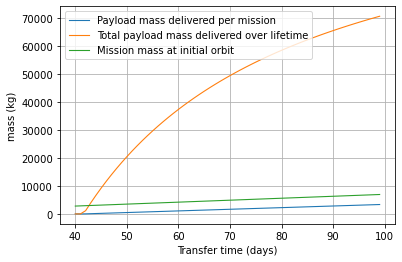

In [66]:
dT_trans = np.arange(40,100)
#m_pay, m_dry, m_prop = np.zeros(len(dT_trans)), np.zeros(len(dT_trans)), np.zeros(len(dT_trans))
m_0, m_prop, m_pay, n_trips, total_savings, P = mission_analysis(dT_trans)
m_pay = [0 if x < 0 else x for x in m_pay]
plt.plot(dT_trans, m_pay, dT_trans, n_trips*m_pay, dT_trans, m_0,linewidth=1.1);plt.legend(["Payload mass delivered per mission","Total payload mass delivered over lifetime","Mission mass at initial orbit"]);plt.grid()
plt.xlabel("Transfer time (days)"); plt.ylabel("mass (kg)")

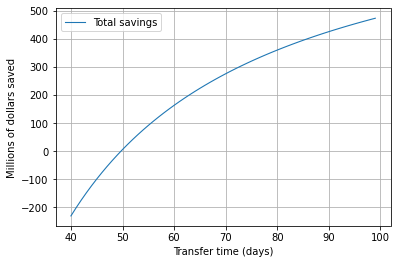

In [67]:
plt.plot(dT_trans, total_savings, linewidth=1.1);plt.legend(["Total savings"])
plt.grid();plt.xlabel("Transfer time (days)"); plt.ylabel("Millions of dollars saved");

Text(0, 0.5, 'mass (kg)')

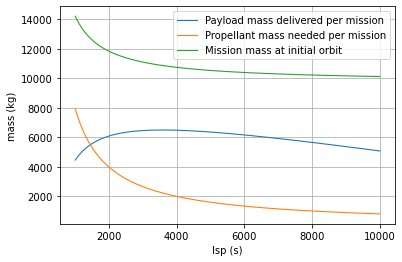

In [90]:
dT_trans = 150
Isp = np.arange(1000,10000)
#m_pay, m_dry, m_prop = np.zeros(len(dT_trans)), np.zeros(len(dT_trans)), np.zeros(len(dT_trans))
m_0, m_prop, m_pay, n_trips, total_savings, P = mission_analysis(dT_trans, Isp=Isp*9.81)
m_pay = [0 if x < 0 else x for x in m_pay]
plt.plot(Isp, m_pay, Isp, m_prop, Isp, m_0,linewidth=1.1);plt.legend(["Payload mass delivered per mission","Propellant mass needed per mission","Mission mass at initial orbit"]);plt.grid()
plt.xlabel("Isp (s)"); plt.ylabel("mass (kg)")